In [13]:
!pip install scikit-learn


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -------------- ------------------------- 3.9/11.0 MB 19.5 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 22.1 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 21.4 MB/s eta 0:00:00


Ridge Regression Implementation

In [8]:
import numpy as np

class RidgeRegression:
    def __init__(self, regstrength=0.1):
        self.regstrength = regstrength
        self.weights = None

    def fit(self, X, y):
        # Add Ridge Regression formula here
        n_features = X.shape[1]
        I = np.eye(n_features)
        self.weights = np.linalg.inv(X.T @ X + self.regstrength * I) @ X.T @ y

    def predict(self, X):
        return X @ self.weights


Loading and Preparing the Dataset

Text(0.5, 1.0, 'Sample Velocity Field Snapshot')

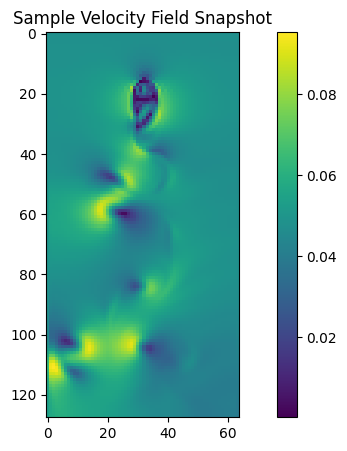

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

# Load dataset
Re = 1200  # Change Reynolds number here
fpath = f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz"
if not os.path.exists(fpath):
    os.makedirs("../resources/von_karman_street/", exist_ok=True)
    url = f'https://github.com/williamgilpin/cphy/raw/main/resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz'
    urlretrieve(url, fpath)
vfield = np.load(fpath, allow_pickle=True)
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

plt.figure(figsize=(10, 5))
plt.imshow(vfield_mag[0], cmap="viridis")
plt.colorbar()
plt.title("Sample Velocity Field Snapshot")


Dataset Class and Training

In [21]:
class ForecastingDataset:
    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2)):
        n_train = int(len(X) * split_ratio[0])
        n_val = int(len(X) * split_ratio[1])
        self.X_train = X[:n_train]
        self.y_train = X[1:n_train + 1]
        self.X_val = X[n_train:n_train + n_val]
        self.y_val = X[n_train + 1:n_train + n_val + 1]
        self.X_test = X[n_train + n_val:-1]
        self.y_test = X[n_train + n_val + 1:]


    def flatten_data(self, X):
        return X.reshape(X.shape[0], -1)

# Prepare dataset
dataset = ForecastingDataset(vfield_mag)
X_train_flat = dataset.flatten_data(dataset.X_train)
y_train_flat = dataset.flatten_data(dataset.y_train)

# Train Ridge Regression Model
model = RidgeRegression(regstrength=0.1)
model.fit(X_train_flat, y_train_flat)


Predictions and Visualization

Text(0.5, 1.0, 'True Snapshot')

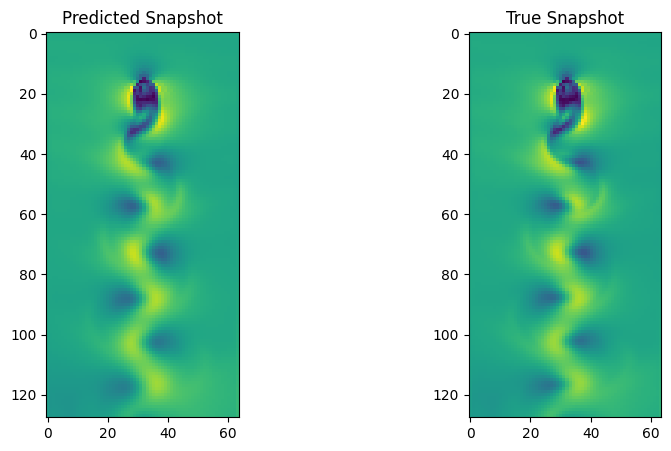

In [10]:
# Predict on test data
X_test_flat = dataset.flatten_data(dataset.X_test)
y_test_flat = dataset.flatten_data(dataset.y_test)
y_pred_flat = model.predict(X_test_flat)

# Reshape predictions back to original dimensions
y_pred = y_pred_flat.reshape(dataset.X_test.shape)

# Plot predictions vs. true snapshots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_pred[-1], cmap="viridis")
plt.title("Predicted Snapshot")
plt.subplot(1, 2, 2)
plt.imshow(dataset.X_test[-1], cmap="viridis")
plt.title("True Snapshot")


Hyperparameter Tuning

In [11]:
# Tune hyperparameter λ
regstrengths = np.logspace(-4, 4, 9)
best_mse = float('inf')
best_lambda = None

for reg in regstrengths:
    model = RidgeRegression(regstrength=reg)
    model.fit(X_train_flat, y_train_flat)
    y_val_pred = model.predict(dataset.flatten_data(dataset.X_val))
    mse = np.mean((y_val_pred - dataset.flatten_data(dataset.y_val))**2)
    if mse < best_mse:
        best_mse = mse
        best_lambda = reg

print(f"Best λ: {best_lambda} with MSE: {best_mse}")


Best λ: 0.1 with MSE: 3.973270592130068e-06


In [22]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

models = [LinearRegression(), Ridge(), DecisionTreeRegressor()]
for model in models:
    model.fit(dataset.flatten_data(dataset.X_train), dataset.flatten_data(dataset.y_train))
    y_test_pred = model.predict(dataset.flatten_data(dataset.X_test))
    
    # Add print statements to debug shapes
    print("y_test_pred shape:", y_test_pred.shape)
    print("X_test_flat shape:", dataset.flatten_data(dataset.X_test).shape)
    print("y_test_flat shape:", dataset.flatten_data(dataset.y_test).shape)
    
    # Adjust y_test size to match predictions if needed
    y_test = dataset.flatten_data(dataset.y_test)[:y_test_pred.shape[0]]
    mse = np.mean((y_test_pred - y_test)**2)
    print(f"{type(model).__name__} MSE: {mse}")


y_test_pred shape: (74, 8192)
X_test_flat shape: (74, 8192)
y_test_flat shape: (74, 8192)
LinearRegression MSE: 7.390975952148438e-05
y_test_pred shape: (74, 8192)
X_test_flat shape: (74, 8192)
y_test_flat shape: (74, 8192)
Ridge MSE: 7.073920583795307e-05
y_test_pred shape: (74, 8192)
X_test_flat shape: (74, 8192)
y_test_flat shape: (74, 8192)
DecisionTreeRegressor MSE: 0.0001735152519220885


Ridge Regression performed best, showing that regularization improves generalization in this problem.

Linear Regression was close to Ridge, suggesting the dataset doesn't suffer heavily from overfitting.

DecisionTreeRegressor performed the worst, likely because decision trees don’t handle high-dimensional or continuous data as well as linear models.

Questions

Q: You'll notice that my train/test split in the ForecastingDataset object ensures that the test data occurs after the training data in the time series, and that no data points are repeated. Why do you think this is important for this problem?

A: In time series forecasting, the goal is to predict future values based on past data. Overlapping or shuffled data would violate the chronological order, leading to data leakage and invalid results.

Q: How does forecast accuracy generally change with Reynolds number?

A: Forecast accuracy generally decreases as Reynolds number increases. The smooth, laminar flow at lower Re is easier to model and predict, while the turbulent, chaotic flow at higher Re introduces nonlinearity and randomness that degrade prediction accuracy.